# Ocean Dependence

Visualizing marine protein consumption (as a proprotion of diet) in countries with high food insecurity.

*Author: Rachel Thoms
<br>Created: 04 Aug 2021
<br>Environment: jupyterlab*

## Style

- Vega chart
- [Doeling Cartogram](https://vega.github.io/vega/examples/dorling-cartogram/) 
- Size is proportion of protein consumption from marine protein (%) color is food insecurity (%)

## Data

- Data: ow_widget_territory (full datasets - [foo_061_rw0_blue_food_supply](https://resourcewatch.carto.com/u/wri-rw/dataset/foo_061_rw0_blue_food_supply_edit) & [foo_064_rw0_food_insecurity](https://resourcewatch.carto.com/u/wri-rw/dataset/foo_064_rw0_food_insecurity_edit))
- Source: [FAO Food Balance Sheet](http://www.fao.org/faostat/en/#data/FBS) & [FAO Food Security Indicators](http://www.fao.org/faostat/en/#data/FS)

## Preparation

### Aliasing and Inserting Data

#### Queries

Protein Supply

```sql
INSERT INTO ow_widget_territory(section, widget, gid_0, name_0, variable, date, value, unit)

SELECT 'indicator' AS section, 'ocean dependence' AS widget, alias.iso AS gid_0, alias.name_0 AS name_0, CONCAT(data.element, ' - ', data.type) AS variable, data.year as date, data.value AS value, data.unit AS unit 

FROM 

(SELECT area, year, unit, element, type, SUM (value) AS value 
FROM foo_061_rw0_blue_food_supply_edit WHERE element = 'Protein supply quantity (g/capita/day)' AND area != 'World' AND year = 2018 GROUP BY area, year, unit, element, type) data

LEFT JOIN ow_aliasing_countries AS alias ON  alias.alias = data.area WHERE alias.iso IS NOT NULL
```

- rows before: 153173
- rows inserted: 334
- rows after: 153517

Food Insecurity

```sql
INSERT INTO ow_widget_territory(section, widget, gid_0, name_0, variable, date, value, unit)
SELECT 'indicator' AS section, 'ocean dependence' AS widget, alias.iso AS gid_0, alias.name_0 AS name_0, 'FoodInsecurity_Prevalence' AS variable, '20182020' AS date, data.y20182020 AS value, unit AS unit 
FROM (SELECT area, y20182020, unit FROM foo_064_rw0_food_insecurity_edit) data
LEFT JOIN ow_aliasing_countries AS alias ON alias.alias = data.area WHERE alias.iso IS NOT NULL
```

- rows before: 153517
- rows inserted: 204
- rows after: 153721
- countries: 204

## Vega

In [2]:
import json
from vega import Vega
from IPython.display import display

In [3]:
def Vega(spec):
    bundle = {}
    bundle['application/vnd.vega.v5+json'] = spec
    display(bundle, raw=True)

In [5]:
widget_width = 800
widget_height = 400

### Version 1 - Food Security as Size

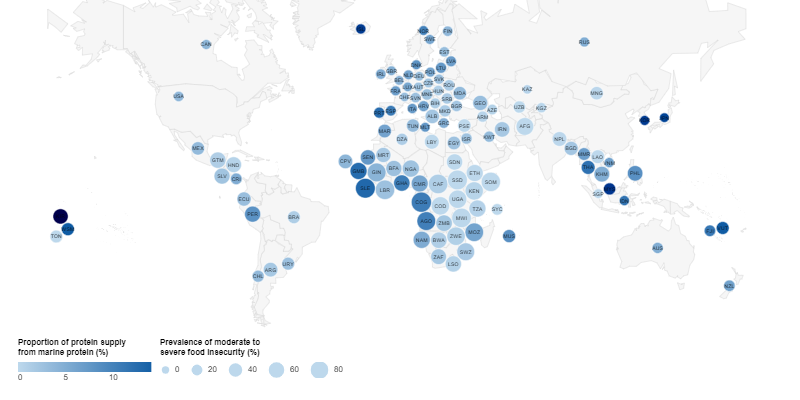

In [8]:
spec=json.loads("""{
  "autosize": "none",
  "data": [
    {
      "format": {"property": "rows", "type": "json"},
      "name": "protein",
      "transform": [
        {
          "as": "variable",
          "expr": "substring(datum.variable,41)",
          "type": "formula"
        },
        {
          "as": "variable",
          "expr": "replace(datum.variable,' ', '_')",
          "type": "formula"
        },
        {
          "as": "variable",
          "expr": "replace(datum.variable, '-', '_')",
          "type": "formula"
        },
        {
          "field": "variable",
          "groupby": ["gid_0"],
          "type": "pivot",
          "value": "value"
        },
        {
          "as": "marine_protein_percent",
          "expr": "(datum.Ocean_Sourced_Food/ datum.Grand_Total)*100",
          "type": "formula"
        }
      ],
      "url": "https://wri-rw.carto.com/api/v2/sql?q=SELECT date AS year, value, variable, gid_0 FROM ow_widget_territory WHERE section = 'indicator' AND widget = 'ocean dependence' AND variable != 'FoodInsecurity_Prevalence' AND value IS NOT NULL ORDER BY gid_0 ASC&env=production&language=en&page[size]=999&rw="
    },
    {
      "format": {"property": "features", "type": "json"},
      "name": "source",
      "url": "https://wri-rw.carto.com/api/v2/sql?format=GeoJSON&q=SELECT ST_Centroid(gadm.the_geom) AS the_geom, data.gid_0, data.name_0, data.variable, data.value FROM (SELECT * FROM ow_widget_territory WHERE variable = 'FoodInsecurity_Prevalence') data INNER JOIN gadm36_0 AS gadm ON gadm.gid_0 = data.gid_0 ORDER BY gid_0 ASC"
    },
    {
      "name": "centroids",
      "source": "source",
      "transform": [
        {
          "as": "x_cart",
          "expr": "test(/KIR/, datum.properties.gid_0) ? -172 : datum.geometry.coordinates[0]",
          "type": "formula"
        },
        {
          "as": "y_cart",
          "expr": "test(/KIR/, datum.properties.gid_0) ? -13 : datum.geometry.coordinates[1]",
          "type": "formula"
        },
        {
          "fields": ["x_cart", "y_cart"],
          "projection": "projection",
          "type": "geopoint"
        }
      ]
    },
    {
      "format": {"property": "features", "type": "json"},
      "name": "geom",
      "transform": [
        {
          "as": ["protein"],
          "fields": ["properties[gid_0]"],
          "from": "protein",
          "key": "gid_0",
          "type": "lookup",
          "values": ["marine_protein_percent"]
        }
      ],
      "url": "https://wri-rw.carto.com/api/v2/sql?format=GeoJSON&q=SELECT  ST_Simplify(gadm.the_geom,0.5) AS the_geom, data.gid_0, data.name_0, data.variable, data.value FROM (SELECT * FROM ow_widget_territory WHERE variable = 'FoodInsecurity_Prevalence') data INNER JOIN gadm36_0 AS gadm ON gadm.gid_0 = data.gid_0 AND data.gid_0 NOT IN ('RUS','AND','ASM','ATG', 'BHR', 'BMU', 'BRB', 'COM', 'CPV', 'DMA', 'FSM', 'GRD', 'HKG', 'KIR', 'KNA', 'LCA', 'LUX', 'MAC', 'MDV', 'MHL', 'MLT', 'MUS', 'NCL', 'NIU', 'NRU', 'PLW', 'PYF', 'SGP', 'SLB', 'STP', 'SYC', 'TKL', 'TON', 'TUV', 'VCT', 'VUT', 'WSM') UNION SELECT gadm.the_geom AS the_geom, data.gid_0, data.name_0, data.variable, data.value FROM (SELECT * FROM ow_widget_territory WHERE variable = 'FoodInsecurity_Prevalence') data INNER JOIN gadm36_0 AS gadm ON gadm.gid_0 = data.gid_0 AND data.gid_0 IN ('AND','ASM','ATG', 'BHR', 'BMU', 'BRB', 'COM', 'CPV', 'DMA', 'FSM', 'GRD', 'HKG', 'KIR', 'KNA', 'LCA', 'LUX', 'MAC', 'MDV', 'MHL', 'MLT', 'MUS', 'NCL', 'NIU', 'NRU', 'PLW', 'PYF', 'SGP', 'SLB', 'STP', 'SYC', 'TKL', 'TON', 'TUV', 'VCT', 'VUT', 'WSM' ) UNION SELECT ST_Simplify(gadm.the_geom,1.2) AS the_geom, data.gid_0, data.name_0, data.variable, data.value FROM (SELECT * FROM ow_widget_territory WHERE variable = 'FoodInsecurity_Prevalence') data INNER JOIN gadm36_0 AS gadm ON gadm.gid_0 = data.gid_0 AND data.gid_0 = 'RUS' ORDER BY gid_0 ASC"
    },
    {
      "format": {"property": "rows", "type": "json"},
      "name": "foodSecurity",
      "transform": [
        {
          "as": ["protein"],
          "fields": ["gid_0"],
          "from": "protein",
          "key": "gid_0",
          "type": "lookup",
          "values": ["marine_protein_percent"]
        },
        {
          "as": ["x"],
          "fields": ["gid_0"],
          "from": "centroids",
          "key": "properties[gid_0]",
          "type": "lookup",
          "values": ["x"]
        },
        {
          "as": ["y"],
          "fields": ["gid_0"],
          "from": "centroids",
          "key": "properties[gid_0]",
          "type": "lookup",
          "values": ["y"]
        }
      ],
      "url": "https://wri-rw.carto.com/api/v2/sql?q=SELECT data.gid_0, data.name_0, data.variable, data.value FROM (SELECT * FROM ow_widget_territory WHERE variable = 'FoodInsecurity_Prevalence') data INNER JOIN gadm36_0 AS gadm ON gadm.gid_0 = data.gid_0 AND value IS NOT NULL ORDER BY gid_0 ASC"
    }
  ],
  "description": "A Dorling cartogram depicting marine protein supply and food insecurity.",
  "height": 400,
  "legends": [
    {
      "clipHeight": 16,
      "direction": "horizontal",
      "fill": "color",
      "gradientLength": {"signal": "width/6"},
      "gradientThickness": 10,
      "labelFontSize": {"signal": "width/100"},
      "orient": "bottom-left",
      "size": "color",
      "title": ["Proportion of protein supply", "from marine protein (%)"],
      "titleFont": "Arial",
      "titleFontSize": {"signal": "width/100"},
      "type": "gradient"
    },
    {
      "clipHeight": 16,
      "direction": "horizontal",
      "labelFontSize": {"signal": "width/100"},
      "orient": "bottom-left",
      "size": "size",
      "symbolFillColor": "#bdd8ec",
      "symbolStrokeColor": "white",
      "title": ["Prevalence of moderate to", "severe food insecurity (%)"],
      "titleFont": "Arial",
      "titleFontSize": {"signal": "width/100"},
      "type": "symbol"
    }
  ],
  "marks": [
    {
      "encode": {
        "enter": {
          "fill": {"field": "protein", "scale": "color"},
          "size": {"field": "value", "scale": "size"},
          "stroke": {"value": "white"},
          "strokeWidth": {"value": 0.5},
          "tooltip": {
            "signal": "{'Country':datum.name_0, 'Proportion of protein supply from marine protein':round(datum.protein*10)/10 + '%', 'Prevalence of moderate to severe food insecurity': format(datum.value, '.1f') + '%'}"
          },
          "x": {"field": "x"},
          "y": {"field": "y"}
        }
      },
      "from": {"data": "foodSecurity"},
      "name": "circles",
      "transform": [
        {
          "forces": [
            {
              "force": "collide",
              "radius": {"expr": "1 + sqrt(datum.size) / (2.2)"}
            },
            {"force": "x", "x": "datum.x"},
            {"force": "y", "y": "datum.y"}
          ],
          "static": true,
          "type": "force"
        }
      ],
      "type": "symbol",
      "zindex": 1
    },
    {
      "encode": {
        "enter": {
          "align": {"value": "center"},
          "baseline": {"value": "middle"},
          "fill": {"value": "black"},
          "fontSize": {"signal": "width/150"},
          "text": {"field": "datum.gid_0"}
        },
        "update": {"x": {"field": "x"}, "y": {"field": "y"}}
      },
      "from": {"data": "circles"},
      "interactive": false,
      "type": "text",
      "zindex": 2
    },
    {
      "encode": {
        "enter": {
          "fill": {"value": "#f6f6f6"},
          "stroke": {"value": "#d8d8d8"},
          "strokeWidth": {"value": 0.5},
          "tooltip": {
            "signal": "{'Country':datum.properties.name_0, 'Proportion of protein supply from marine protein': isValid(datum.protein) ? round(datum.protein*10)/10 + '%' : 'No data' , 'Prevalence of moderate to severe food insecurity': isValid(datum.properties.value) ? format(datum.properties.value, '.1f') + '%' : 'No data'}"
          }
        }
      },
      "from": {"data": "geom"},
      "transform": [{"projection": "projection", "type": "geoshape"}],
      "type": "shape",
      "zindex": 0
    }
  ],
  "projections": [
    {
      "extent": {"signal": "[[0,-(height/15)],[width,height-(height/3.5)]]"},
      "fit": {"signal": "data('source')"},
      "name": "projection",
      "type": "mercator"
    }
  ],
  "scales": [
    {
      "domain": {"data": "foodSecurity", "field": "value"},
      "name": "size",
      "range": [{"signal": "ceil(width/10)"}, {"signal": "width/2"}]
    },
    {
      "domain": {"data": "foodSecurity", "field": "protein"},
      "domainMax": 14,
      "name": "color",
      "nice": true,
      "range": ["#bdd8ec", "#145fa6"],
      "type": "linear"
    }
  ],
  "width": 800
}""")
vegaview=dict(spec)
Vega(vegaview)

### Version 2 - Marine Protein as Size

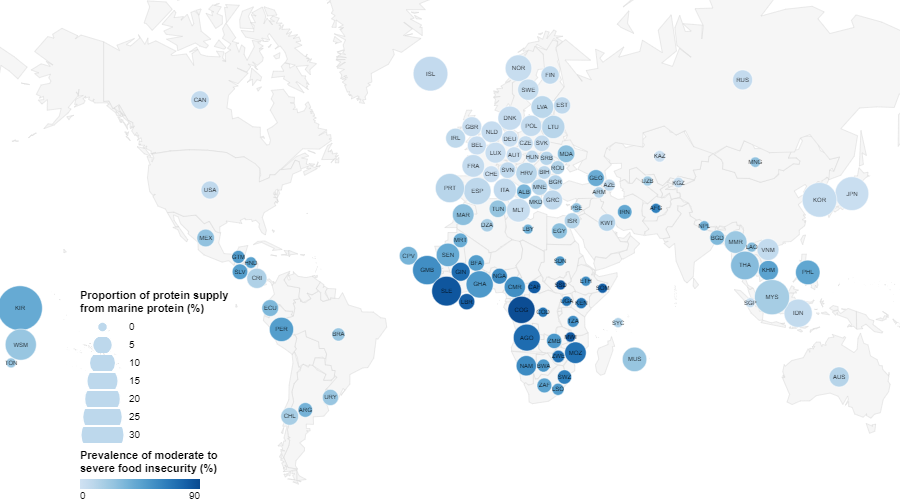

In [5]:
spec=json.loads("""{
  "$schema": "https://vega.github.io/schema/vega/v5.json",
  "description": "A Dorling cartogram depicting marine protein supply and food insecurity.",
  "width": 900,
  "height": 500,
  "autosize": "none",
  "projections": [
    {"name": "projection", "type": "mercator", "center": [0, 20]}
  ],
  "data": [
    {
      "name": "protein",
      "url": "https://wri-rw.carto.com/api/v2/sql?q=SELECT date AS year, value, variable, gid_0 FROM ow_widget_territory WHERE section = 'indicator' AND widget = 'ocean dependence' AND variable != 'FoodInsecurity_Prevalence' AND value IS NOT NULL ORDER BY gid_0 ASC",
      "format": {"type": "json", "property": "rows"},
      "transform": [
        {
          "type": "formula",
          "expr": "substring(datum.variable,41)",
          "as": "variable"
        },
        {
          "type": "formula",
          "expr": "replace(datum.variable,' ', '_')",
          "as": "variable"
        },
        {
          "type": "formula",
          "expr": "replace(datum.variable, '-', '_')",
          "as": "variable"
        },
        {
          "type": "pivot",
          "groupby": ["gid_0"],
          "field": "variable",
          "value": "value"
        },
        {
          "type": "formula",
          "expr": "(datum.Ocean_Sourced_Food/ datum.Grand_Total)*100",
          "as": "marine_protein_percent"
        }
      ]
    },
    {
      "name": "source",
      "url": "https://wri-rw.carto.com/api/v2/sql?format=GeoJSON&q=SELECT  ST_Simplify(gadm.the_geom,0.5) AS the_geom, data.gid_0, data.name_0, data.variable, data.value FROM (SELECT * FROM ow_widget_territory WHERE variable = 'FoodInsecurity_Prevalence') data LEFT JOIN gadm36_0 AS gadm ON gadm.gid_0 = data.gid_0 WHERE gadm.gid_0 IS NOT NULL AND data.gid_0 NOT IN ('RUS','AND','ASM','ATG', 'BHR', 'BMU', 'BRB', 'COM', 'CPV', 'DMA', 'FSM', 'GRD', 'HKG', 'KIR', 'KNA', 'LCA', 'LUX', 'MAC', 'MDV', 'MHL', 'MLT', 'MUS', 'NCL', 'NIU', 'NRU', 'PLW', 'PYF', 'SGP', 'SLB', 'STP', 'SYC', 'TKL', 'TON', 'TUV', 'VCT', 'VUT', 'WSM') UNION SELECT gadm.the_geom AS the_geom, data.gid_0, data.name_0, data.variable, data.value FROM (SELECT * FROM ow_widget_territory WHERE variable = 'FoodInsecurity_Prevalence') data LEFT JOIN gadm36_0 AS gadm ON gadm.gid_0 = data.gid_0 WHERE gadm.gid_0 IS NOT NULL AND data.gid_0 IN ('AND','ASM','ATG', 'BHR', 'BMU', 'BRB', 'COM', 'CPV', 'DMA', 'FSM', 'GRD', 'HKG', 'KIR', 'KNA', 'LCA', 'LUX', 'MAC', 'MDV', 'MHL', 'MLT', 'MUS', 'NCL', 'NIU', 'NRU', 'PLW', 'PYF', 'SGP', 'SLB', 'STP', 'SYC', 'TKL', 'TON', 'TUV', 'VCT', 'VUT', 'WSM' ) UNION SELECT ST_Simplify(gadm.the_geom,1.2) AS the_geom, data.gid_0, data.name_0, data.variable, data.value FROM (SELECT * FROM ow_widget_territory WHERE variable = 'FoodInsecurity_Prevalence') data LEFT JOIN gadm36_0 AS gadm ON gadm.gid_0 = data.gid_0 WHERE gadm.gid_0 IS NOT NULL AND data.gid_0 = 'RUS' ORDER BY gid_0 ASC",
      "format": {"type": "json", "property": "features"},
      "transform": [
        {
          "type": "lookup",
          "from": "protein",
          "key": "gid_0",
          "fields": ["properties[gid_0]"],
          "values": ["marine_protein_percent"],
          "as": ["protein"]
        }
      ]
    },
    {
      "name": "geom",
      "source": "source",
      "transform": [
        {
          "type": "formula",
          "as": "centroid",
          "expr": "geoCentroid('projection', datum)"
        },
        {
          "type": "lookup",
          "from": "protein",
          "key": "gid_0",
          "fields": ["properties[gid_0]"],
          "values": ["marine_protein_percent"],
          "as": ["protein"]
        }
      ]
    },
    {
      "name": "foodSecurity",
      "url": "https://wri-rw.carto.com/api/v2/sql?q=SELECT data.gid_0, data.name_0, data.variable, data.value FROM (SELECT * FROM ow_widget_territory WHERE variable = 'FoodInsecurity_Prevalence') data LEFT JOIN gadm36_0 AS gadm ON gadm.gid_0 = data.gid_0 WHERE gadm.gid_0 IS NOT NULL AND value IS NOT NULL ORDER BY gid_0 ASC",
      "format": {"type": "json", "property": "rows"},
      "transform": [
        {
          "type": "lookup",
          "from": "protein",
          "key": "gid_0",
          "fields": ["gid_0"],
          "values": ["marine_protein_percent"],
          "as": ["protein"]
        },
        {
          "type": "lookup",
          "from": "geom",
          "key": "properties[gid_0]",
          "fields": ["gid_0"],
          "values": ["centroid"],
          "as": ["centroid"]
        },
        {"type": "filter", "expr": "isValid(datum.centroid[0])"},
        {
          "type": "formula",
          "expr": "test(/USA/, datum.gid_0) ? [210,190] : datum.centroid",
          "as": "centroid"
        },
        {
          "type": "formula",
          "expr": "test(/CAN/, datum.gid_0) ? [200,100] : datum.centroid",
          "as": "centroid"
        },
        {
          "type": "formula",
          "expr": "test(/KIR/, datum.gid_0) ? [20,310] : datum.centroid",
          "as": "centroid"
        }
      ]
    }
  ],
  "scales": [
    {
      "name": "size",
      "domain": {"data": "foodSecurity", "field": "protein"},
      "range": [100, 2000]
    },
    {
      "name": "color",
      "type": "linear",
      "nice": true,
      "domain": {"data": "foodSecurity", "field": "value"},
      "range": {"scheme": "blues"}
    }
  ],
  "legends": [
    {
      "title": ["Prevalence of moderate to", "severe food insecurity (%)"],
      "orient": "none",
      "legendX": 80,
      "legendY": 450,
      "type": "gradient",
      "direction": "horizontal",
      "gradientLength": 120,
      "gradientThickness": 10,
      "size": "color",
      "fill": "color",
      "clipHeight": 16
    },
    {
      "title": ["Proportion of protein supply", "from marine protein (%)"],
      "orient": "none",
      "legendX": 80,
      "legendY": 290,
      "type": "symbol",
      "size": "size",
      "symbolFillColor": "#bdd8ec",
      "symbolStrokeColor": "white",
      "clipHeight": 16
    }
  ],
  "marks": [
    {
      "name": "circles",
      "type": "symbol",
      "from": {"data": "foodSecurity"},
      "zindex": 1,
      "encode": {
        "enter": {
          "size": {"scale": "size", "field": "protein"},
          "fill": {"scale": "color", "field": "value"},
          "stroke": {"value": "white"},
          "strokeWidth": {"value": 0.5},
          "x": {"field": "centroid[0]"},
          "y": {"field": "centroid[1]"},
          "tooltip": {
            "signal": "{title:datum.name_0, 'Proportion of protein supply from marine protein':round(datum.protein*10)/10 + '%', 'Prevalence of moderate to severe food insecurity)': format(datum.value, '.1f') + '%'}"
          }
        }
      },
      "transform": [
        {
          "type": "force",
          "static": true,
          "forces": [
            {
              "force": "collide",
              "radius": {"expr": "1 + sqrt(datum.size) / 2.2"}
            },
            {"force": "x", "x": "datum.centroid[0]"},
            {"force": "y", "y": "datum.centroid[1]"}
          ]
        }
      ]
    },
    {
      "type": "text",
      "interactive": false,
      "from": {"data": "circles"},
      "zindex": 2,
      "encode": {
        "enter": {
          "align": {"value": "center"},
          "baseline": {"value": "middle"},
          "fontSize": {"value": 6},
          "text": {"field": "datum.gid_0"},
          "fill": {"value": "black"}
        },
        "update": {"x": {"field": "x"}, "y": {"field": "y"}}
      }
    },
    {
      "type": "shape",
      "from": {"data": "source"},
      "zindex": 0,
      "encode": {
        "enter": {
          "strokeWidth": {"value": 0.5},
          "stroke": {"value": "#d8d8d8"},
          "fill": {"value": "#f6f6f6"},
          "tooltip": {
            "signal": "{title:datum.properties.name_0, 'Proportion of protein supply from marine protein': isValid(datum.protein) ? round(datum.protein*10)/10 + '%' : 'No data' , 'Prevalence of moderate to severe food insecurity': isValid(datum.properties.value) ? format(datum.properties.value, '.1f') + '%' : 'No data'}"
          }
        }
      },
      "transform": [{"type": "geoshape", "projection": "projection"}]
    }
  ]
}""")
vegaview=dict(spec)
Vega(vegaview)